<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [49]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Sat Apr 24 16:11:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   5128MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [50]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [51]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [52]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [53]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [54]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## 1. Build a model generator

In [55]:
import random
import gc
class ModelFactory:
    @staticmethod
    def get_conv_layer(depth, inshape=None, force_stride_size=False):
        out_layers = []
        filter_size = random.choice([2, 3, 4, 5])
        stride_size = random.choice([1, 2, 3])
        stride_size = stride_size if stride_size < filter_size else filter_size

        # In case there is an exception, the caller will
        # set this and call again
        stride_size = 1 if force_stride_size else stride_size

        stride_size = (stride_size, stride_size, )
        filter_shape = tuple([filter_size, filter_size,])
        act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
        pd = random.choice(['same', 'valid'])

        if None != inshape:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                input_shape=inshape,\
                                                strides=stride_size,\
                                                activation=act_fn)
        else:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                strides=stride_size,\
                                                activation=act_fn)
        out_layers.append(conv_layer)

        if random.choice([True, False]):
            pool_size = random.choice([2, 3, 4])
            out_layers.append(tf.keras.layers.MaxPooling2D(\
                                                           pool_size,\
                                                           pool_size,))
        
        if random.choice([True, False]):
            out_layers.append(tf.keras.layers.SpatialDropout2D(0.25))

        return out_layers

    @staticmethod
    def generate_model_internal(inshp, nlabels:int, modelname:str, fss:bool):
        layer_neurons = []
        n_conv_layers = random.choice([1, 2, 3,])
        layer_depth = sorted([\
                random.choice([32, 64, 128, 256, 512, 1024]) \
                    for _ in range(n_conv_layers)])

        for i in range(1, len(layer_depth)):
            if layer_depth[i] <= layer_depth[i-1]:
                layer_depth[i] = 2 * layer_depth[i-1]

        # Add the first Convolutional layer
        model = tf.keras.Sequential(name=modelname)
        for lyr in ModelFactory.get_conv_layer(layer_depth[0], inshp, force_stride_size=fss):
            model.add(lyr)
        
        # Add zero or more additional convoluationa layer
        for d in layer_depth[1:]:
            for lyr in ModelFactory.get_conv_layer(d, inshape=None, force_stride_size=fss):
                model.add(lyr)

        # Flatten
        model.add(tf.keras.layers.Flatten())

        # Add zero or more dense layers
        n_dense = random.choice([0, 1, 2])
        for _ in range(n_dense - 1):
            act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
            layer = tf.keras.layers.Dense(\
                                random.choice([32, 64, 128, 256, 512]),
                                activation=act_fn)
            model.add(layer)
            if random.choice([True, False]):
                layer = tf.keras.layers.Dropout(0.25)
                model.add(layer)
        
        # Add the final Dense layer
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        
        return model

    @staticmethod
    def print_model(model):
        plot = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())

    @staticmethod
    def generate_model_size(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        if (-1 == max_params):
            try:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            False)
            except:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            True)
            ModelFactory.print_model(model)
            return model
        else:
            # Make 10 attempts to generate a model with the number of
            # trainable params less than the one specified
            for i in range(10):
                gc.collect()
                logging.debug(f"Attempt {i}")
                try:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                False)
                except:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                True)
                if model.count_params() < max_params:
                    ModelFactory.print_model(model)
                    gc.collect()
                    return model

                gc.collect()
            return None
    
    @staticmethod
    def generate_model(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        """
        Tries to make a model with the number of trainable params less
        than the specified number. If it is not able to do so, it will
        create a model with a greater number regardless
        """
        model = ModelFactory.generate_model_size(\
                                                 inshp,\
                                                 nlabels,\
                                                 modelname,\
                                                 max_params)
        if None == model:
            model = ModelFactory.generate_model_size(\
                                                     inshp,\
                                                     nlabels,\
                                                     modelname,\
                                                     -1)
        return model

# Generate the Base Models

In [56]:

def get_formatted_json(jsonstr):
    j = json.loads(jsonstr)
    return json.dumps(j, indent=4)

get_model_name = lambda n : f"ensemble-base-model-{n}"
get_model_json_filename = lambda n : f"save-ensemble-base-model-{n}.json"

import json
def generate_base_models(n_models):
    n_classes = len(np.unique(np.concatenate((trainY, valY))))
    for i in range(n_models):
        modelname = get_model_name(i)
        filename = get_model_json_filename(i)
        model = ModelFactory.generate_model(trainX[0].shape, n_classes, modelname, 9_500_000)
        model_json = model.to_json()
        with open(f"{DRIVE_FOLDER}/{filename}", "w") as f:
            f.write(get_formatted_json(model_json))
            f.close()

# Train each model

In [57]:
def train_model_internal(model, plot):
    print(model.summary())
    print()
    N_EPOCHS = 2
    model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    if model.count_params() < 1_500_000:
        print("Using decay of learning reate")
        cb = get_callbacks_decay_after(5, model.name)
    else:
        print("Avoiding decay of learning reate")
        cb = get_callbacks_decay_after(-1, model.name)
    history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=cb)
    if plot:
        plot.plot_history(history, 100, model.name)

def train_model(i, plot):
    print('=' * 80)
    print('=' * 80)
    print(f"Training model {i}")
    print()
    fname = get_model_json_filename(i)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        train_model_internal(model, plot)

In [58]:
def load_model(n):
    fname = get_model_json_filename(n)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    return model

def load_model_weight(model, n):
    weight_file = f"{DRIVE_FOLDER}/ckp-{model.name}"
    model.load_weights(weight_file)

def get_predictions(model, X):
    x = model.predict(X)
    return x


In [96]:
N_BASE_MODELS = 10

train_pred_fname = lambda i: f"{DRIVE_FOLDER}/train_pred_{i}.txt"
val_pred_fname = lambda i: f"{DRIVE_FOLDER}/val_pred_{i}.txt"

def train_all_models(plot):
    for i in range(N_BASE_MODELS):
        train_model(i, plot)

def evaluate_and_save(i):
    print(f"--------------------- {i} -----------------------")
    model = load_model(i)
    load_model_weight(model, i)
    trainPred = get_predictions(model, trainX)
    valPred = get_predictions(model, valX)
    np.savetxt(train_pred_fname(i), trainPred, delimiter=',')
    np.savetxt(val_pred_fname(i), valPred, delimiter=',')
    gc.collect()

def evaluate_and_save_all():
    for i in range(N_BASE_MODELS):
        evaluate_and_save(i)

def get_train_predictions(N):
    ret = []
    for i in range(N):
        ret.append(np.loadtxt(train_pred_fname(i), delimiter=','))
    return ret

def get_val_predictions(N):
    ret = []
    for i in range(N):
        ret.append(np.loadtxt(val_pred_fname(i), delimiter=','))
    return ret

from sklearn.metrics import accuracy_score
def get_accuracy(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_true, y_pred)
    return acc

def get_ensemble_predictions(pred_array):
    added = pred_array[0].copy()
    for a in pred_array[1:]:
        added = added + a
    return added

import seaborn as sns
def simple_ensemble():
    val_accuracies = []
    train_accuracies = []
    model_names = []

    # Load the saved training predictions
    train_predictions = get_train_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the training
    #    by summing over the predictions for each base learner
    ensemble_train_prediction = get_ensemble_predictions(train_predictions)

    # Load the saved validation predictions
    val_predictions = get_val_predictions(N_BASE_MODELS)

    # Get the ensemble prediction for the validation
    #    by summing over the predictions for each base learner
    ensemble_val_prediction = get_ensemble_predictions(val_predictions)

    # Get the accuracy for the validation predictions for each base models
    for n, i in enumerate(val_predictions):
        acc = get_accuracy(valY, i)
        val_accuracies.append(acc)

    # Append the validation accuracy of the ensemble
    val_accuracies.append(get_accuracy(valY, ensemble_val_prediction))

    # Get the accuracy for the training predictions for each base model
    for n, i in enumerate(train_predictions):
        acc = get_accuracy(trainY, i)
        train_accuracies.append(acc)

    # Append the training accuracy for the ensemble
    train_accuracies.append(get_accuracy(trainY, ensemble_train_prediction))

    # Add the model names
    for i in range(len(train_predictions)):
        model_names.append(f"Model - {i}")
    model_names.append("Ensemble")

    # Create a dataframe
    val_accuracies = pd.Series(val_accuracies)
    train_accuracies = pd.Series(train_accuracies)
    model_names = pd.Series(model_names)
    df = pd.DataFrame(\
        { \
            "val_accuracies": val_accuracies,\
            "train_accuracies": train_accuracies,\
            "model_names": model_names\
        }\
    )

    plot = sns.barplot(y='model_names', x='val_accuracies', data=df, orient='h')
    plot.set_title('Simple Ensemble (adding all predictions)')
    plt.show()


import pandas as pd
def main():

    #plot = Plot()
    #generate_base_models(N_BASE_MODELS)
    #print("Training all models ...")
    #train_all_models(plot)
    #print("Done")
    #print("Evaluate and save ...")
    #evaluate_and_save_all()
    #print("Done")
    simple_ensemble()



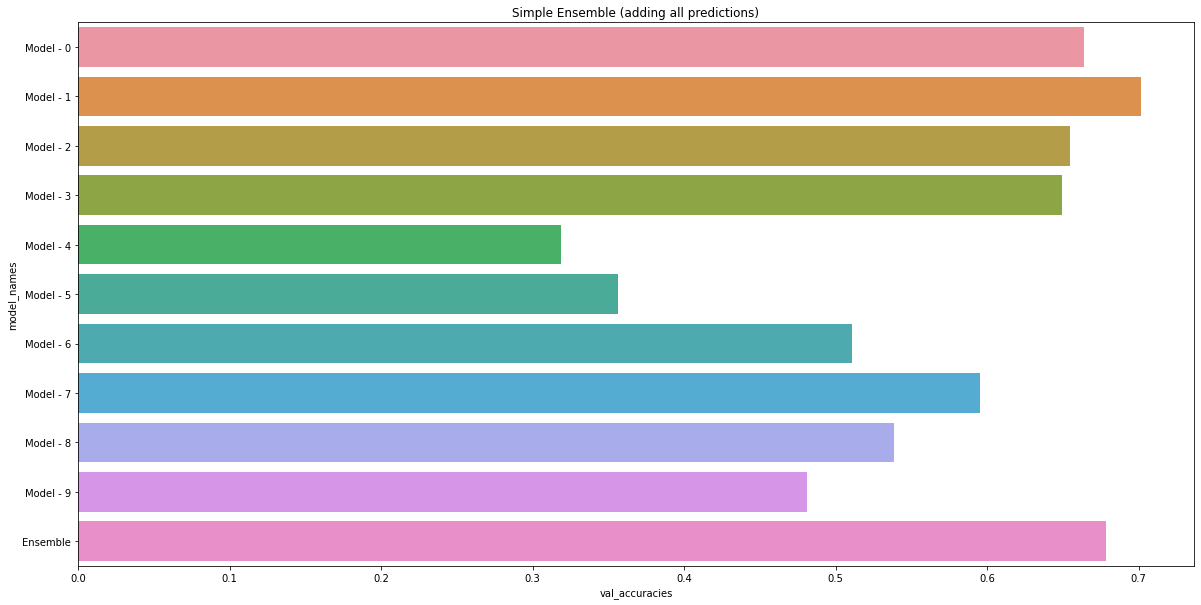

In [97]:
main()